In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

# Tsukuba Modelling

### Loading in Tsukuba Dataset

In [3]:
tsukuba = pd.read_csv("data/tsukuba_ac.csv").iloc[:,:24]
tsukuba = tsukuba[tsukuba['P/W (hp/t)'] != '#DIV/0!']
tsukuba['P/W (hp/t)'] = tsukuba['P/W (hp/t)'].apply(np.float64)
tsukuba['Year'] = tsukuba['Year'].apply(np.float64)
tsukuba.dropna(axis=0, how='all', inplace=True)


def lt_in_seconds(time):
    minutes, seconds = time.strip().split(':')
    return 60*np.float64(minutes) + np.float64(seconds)

def msrp_float(msrp):
    if pd.isna(msrp):
        return np.float64(None)
    else:
        msrp = msrp.replace('$','').replace(',','').replace('>','')
        return np.float64(msrp)

tsukuba['MSRP (2022 USD)'] = tsukuba['MSRP (2022 USD)'].apply(msrp_float)

z='0:00.000'
tsukuba['Lap Time I']= tsukuba['Lap Time I'].fillna(z).apply(lt_in_seconds)
tsukuba['Lap Time II']= tsukuba['Lap Time II'].fillna(z).apply(lt_in_seconds)
tsukuba['Lap Time III']= tsukuba['Lap Time III'].fillna(z).apply(lt_in_seconds)

tsukuba_timed = (
    tsukuba.loc[tsukuba['Lap Time I'] > 0]
)

tsukuba_irl = (
    tsukuba.loc[tsukuba['Source']=='irl']
    .drop(columns=['Author']))

tsukuba_ac = tsukuba.loc[tsukuba['Source']!='irl']

In [4]:
txt = " ({numcar} cars)"

print("Datasets:\n")
print("All Tsukuba Data"+txt.format(numcar = tsukuba.shape[0]))
display(tsukuba.head())
print("\nTimed  Data Only"+txt.format(numcar = tsukuba_timed.shape[0]))
display(tsukuba_timed.head())
print("\nReal Life Data Only"+txt.format(numcar = tsukuba_irl.shape[0]))
display(tsukuba_irl.head())
print("\nAssetto Corsa Data"+txt.format(numcar = tsukuba_ac.shape[0]))
display(tsukuba_ac.head())

Datasets:

All Tsukuba Data (1355 cars)


,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,Tire III,Lap Time III,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,_HD,Author,Source,Comments / Other Times
0,2016.0,Abarth,124 Spider,0.000,NaN,NaN,0.000,NaN,NaN,0.0,...,271.0,1070.0,165.420561,FR,MT,NaN,L,?,link,NaN
1,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,NaN,0.0,...,205.0,1025.0,139.512195,FF,MT,3.5,L,Kunos,AC,NaN
2,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.000,NaN,NaN,0.0,...,206.0,1092.0,123.626374,FF,MT,NaN,L,Abarth,irl,NaN
3,2017.0,Abarth,595 Pista,71.661,0.0,NaN,0.000,NaN,NaN,0.0,...,252.0,1025.0,176.585366,FF,MT,3.0,L,Simaothekid,link,hp too high for whp
4,1964.0,Abarth,595 SS,91.018,0.0,NaN,0.000,NaN,NaN,0.0,...,38.0,470.0,59.574468,RR,MT,3.0,L,Kunos,AC,NaN



Timed  Data Only (707 cars)


,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,Tire III,Lap Time III,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,_HD,Author,Source,Comments / Other Times
1,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,NaN,0.0,...,205.0,1025.0,139.512195,FF,MT,3.5,L,Kunos,AC,NaN
2,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.000,NaN,NaN,0.0,...,206.0,1092.0,123.626374,FF,MT,NaN,L,Abarth,irl,NaN
3,2017.0,Abarth,595 Pista,71.661,0.0,NaN,0.000,NaN,NaN,0.0,...,252.0,1025.0,176.585366,FF,MT,3.0,L,Simaothekid,link,hp too high for whp
4,1964.0,Abarth,595 SS,91.018,0.0,NaN,0.000,NaN,NaN,0.0,...,38.0,470.0,59.574468,RR,MT,3.0,L,Kunos,AC,NaN
5,2009.0,Abarth,Punto,71.601,0.0,NaN,0.000,NaN,NaN,0.0,...,230.0,1260.0,132.539682,FF,MT,3.5,L,Simaothekid,link,NaN



Real Life Data Only (338 cars)


,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,Tire III,Lap Time III,...,WHP,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,_HD,Source,Comments / Other Times
2,2008.0,Abarth,500 EsseEsse,72.997,0.0,NaN,0.0,NaN,NaN,0.0,...,135.0,206.0,1092.0,123.626374,FF,MT,NaN,L,irl,NaN
32,2001.0,Alfa Romeo,147 2.0 TS,77.860,0.0,NaN,0.0,NaN,NaN,0.0,...,129.0,158.0,1276.0,101.097179,FF,MT,NaN,R,irl,NaN
33,2005.0,Alfa Romeo,147 GTA,70.010,0.0,NaN,0.0,NaN,NaN,0.0,...,215.0,258.0,1394.0,154.232425,FF,MT,NaN,R,irl,NaN
39,2003.0,Alfa Romeo,156 GTA,72.900,0.0,NaN,0.0,NaN,NaN,0.0,...,242.0,277.0,1410.0,171.631206,RR,MT,NaN,L,irl,NaN
58,2017.0,Alpine,A110,65.040,0.0,NaN,0.0,NaN,NaN,0.0,...,234.0,317.0,1111.0,210.621062,MR,AT,NaN,L,irl,NaN



Assetto Corsa Data (1017 cars)


,Year,Brand,Model,Lap Time I,RC I,Tire II,Lap Time II,RC II,Tire III,Lap Time III,...,WTQ,Weight,P/W (hp/t),Layout,Trans,Rating,_HD,Author,Source,Comments / Other Times
0,2016.0,Abarth,124 Spider,0.000,NaN,NaN,0.000,NaN,NaN,0.0,...,271.0,1070.0,165.420561,FR,MT,NaN,L,?,link,NaN
1,2008.0,Abarth,500 EsseEsse,71.907,0.0,SM,71.065,1.0,NaN,0.0,...,205.0,1025.0,139.512195,FF,MT,3.5,L,Kunos,AC,NaN
3,2017.0,Abarth,595 Pista,71.661,0.0,NaN,0.000,NaN,NaN,0.0,...,252.0,1025.0,176.585366,FF,MT,3.0,L,Simaothekid,link,hp too high for whp
4,1964.0,Abarth,595 SS,91.018,0.0,NaN,0.000,NaN,NaN,0.0,...,38.0,470.0,59.574468,RR,MT,3.0,L,Kunos,AC,NaN
5,2009.0,Abarth,Punto,71.601,0.0,NaN,0.000,NaN,NaN,0.0,...,230.0,1260.0,132.539682,FF,MT,3.5,L,Simaothekid,link,NaN


In [5]:
assert tsukuba_ac.shape[0] + tsukuba_irl.shape[0] == tsukuba.shape[0]

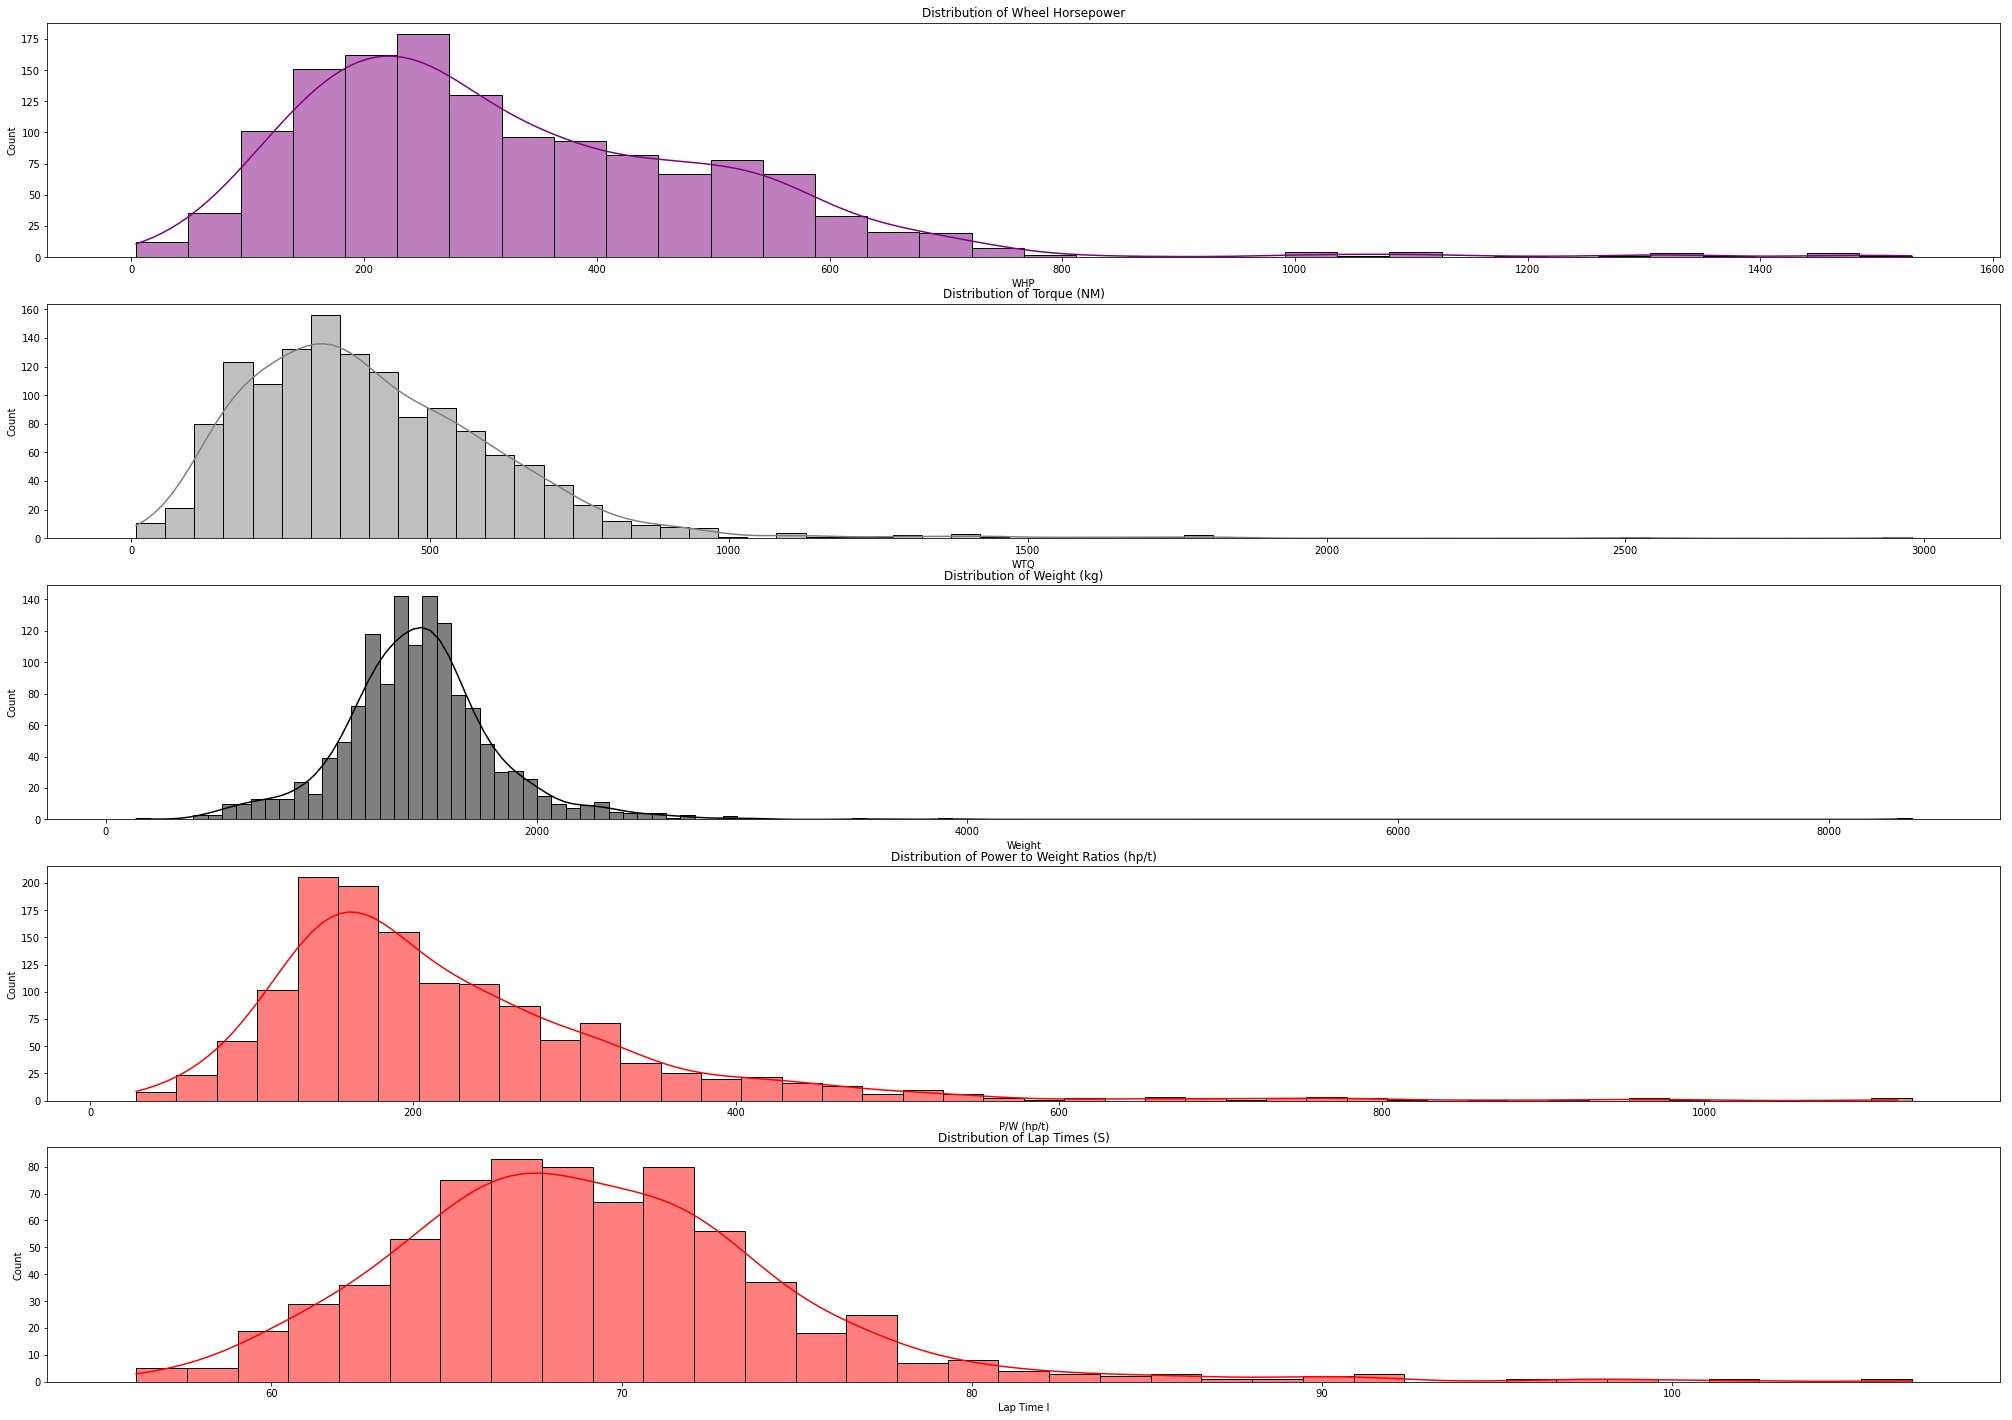

In [6]:
f, axes = plt.subplots(5, 1, figsize=(35,25),)

z = sns.histplot(
    data=tsukuba,
    x='WHP',
    ax=axes[0],
    color="purple",
    kde=True,
    ).set(title="Distribution of Wheel Horsepower")

z2 = sns.histplot(
    data=tsukuba,
    x='WTQ',
    ax=axes[1],
    color="grey",
    kde=True,
    ).set(title="Distribution of Torque (NM)")

z1 = sns.histplot(
    data=tsukuba,
    x='Weight',
    ax=axes[2],
    color="black",
    kde=True,
    ).set(title="Distribution of Weight (kg)")

y = sns.histplot(
    data=tsukuba,
    x='P/W (hp/t)',
    binwidth=25,
    ax=axes[3],
    color="red",
    kde=True,
    ).set(title="Distribution of Power to Weight Ratios (hp/t)")

y = sns.histplot(
    data=tsukuba_timed,
    x='Lap Time I',
    ax=axes[4],
    color="red",
    kde=True,
    ).set(title="Distribution of Lap Times (S)")

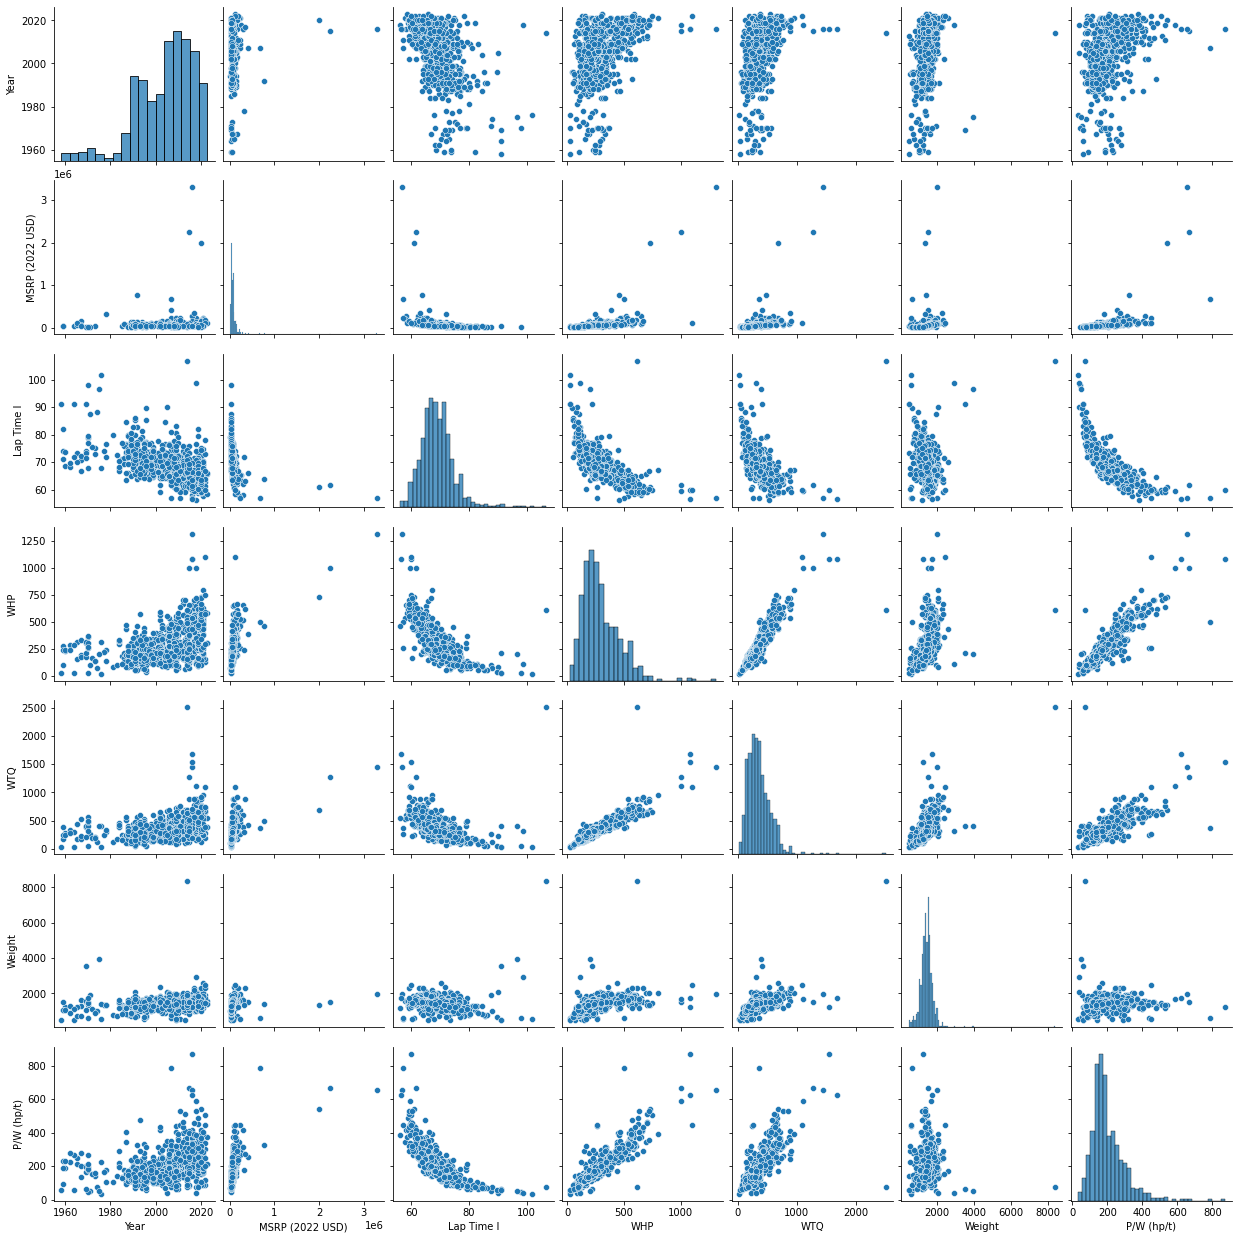

In [7]:
cols = [
'Year',
'MSRP (2022 USD)',
 'Lap Time I',
 'WHP',
 'WTQ',
 'Weight',
 'P/W (hp/t)',]
subsetdf = tsukuba_timed[cols]
sns.pairplot(data = subsetdf)

In [7]:
tsukuba_brand_mu = pd.DataFrame(tsukuba_timed.groupby('Brand').mean())
tsukuba_brand_med = pd.DataFrame(tsukuba_timed.groupby('Brand').median())
display(tsukuba_brand_mu.head())
display(tsukuba_brand_med.head())

,Year,Lap Time I,RC I,Lap Time II,RC II,Lap Time III,RC III,MSRP (2022 USD),WHP,WTQ,Weight,P/W (hp/t),Rating
Brand,,,,,,,,,,,,,
Abarth,2002.833333,74.355833,0.500000,11.844167,1.0,0.0,NaN,29312.605000,138.833333,201.833333,1022.000000,128.983596,3.300000
Acura,2002.428571,69.718429,0.142857,0.000000,NaN,0.0,NaN,73975.034286,228.000000,242.857143,1361.714286,161.800213,3.142857
Alfa Romeo,1999.000000,70.534778,0.277778,10.881222,1.0,0.0,NaN,102861.232667,230.055556,305.277778,1295.833333,178.803226,3.266667
Alpine,2017.000000,64.742000,0.000000,0.000000,NaN,0.0,NaN,57385.000000,225.000000,303.500000,1095.500000,205.310531,4.500000
Ariel,2009.000000,60.971000,0.000000,0.000000,NaN,0.0,NaN,101467.670000,261.000000,242.000000,595.000000,438.655462,4.000000


,Year,Lap Time I,RC I,Lap Time II,RC II,Lap Time III,RC III,MSRP (2022 USD),WHP,WTQ,Weight,P/W (hp/t),Rating
Brand,,,,,,,,,,,,,
Abarth,2008.5,71.7840,0.0,0.0,1.0,0.0,NaN,28860.245,155.0,218.0,1058.5,136.025939,3.5
Acura,2002.0,70.5310,0.0,0.0,NaN,0.0,NaN,37293.130,190.0,184.0,1260.0,157.676348,3.5
Alfa Romeo,2005.0,71.1735,0.0,0.0,0.0,0.0,NaN,60847.790,199.0,267.5,1357.5,149.591621,3.5
Alpine,2017.0,64.7420,0.0,0.0,NaN,0.0,NaN,57385.000,225.0,303.5,1095.5,205.310531,4.5
Ariel,2009.0,60.9710,0.0,0.0,NaN,0.0,NaN,101467.670,261.0,242.0,595.0,438.655462,4.0


In [10]:
subsetdf = subsetdf.assign(pwr= subsetdf['P/W (hp/t)'])
subsetdf = subsetdf.assign(lt= subsetdf['Lap Time I'])
subsetdf['pwr'] = (
    (subsetdf['pwr'] - subsetdf['pwr'].mean())/subsetdf['pwr'].std()
    )
subsetdf['lt'] = (
    (subsetdf['lt'] - subsetdf['lt'].mean())/subsetdf['lt'].std()
    )

pwr = subsetdf['pwr']
lt = subsetdf['lt']
outcome, predictors = patsy.dmatrices('pwr ~ lt', subsetdf)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pwr   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     883.5
Date:                Tue, 24 Jan 2023   Prob (F-statistic):          1.76e-126
Time:                        20:10:40   Log-Likelihood:                -715.53
No. Observations:                 707   AIC:                             1435.
Df Residuals:                     705   BIC:                             1444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.622e-16      0.025  -6.47e-15      1.000      -0.049       0.049
lt            -0.7458      0.025    -29.723      0.000      -0.795      -0.697
==============================================================================
Omnibus:                      472.361   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6686.290
Skew:                           2.821   Prob(JB):                         0.00
Kurtosis:                      16.969   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""